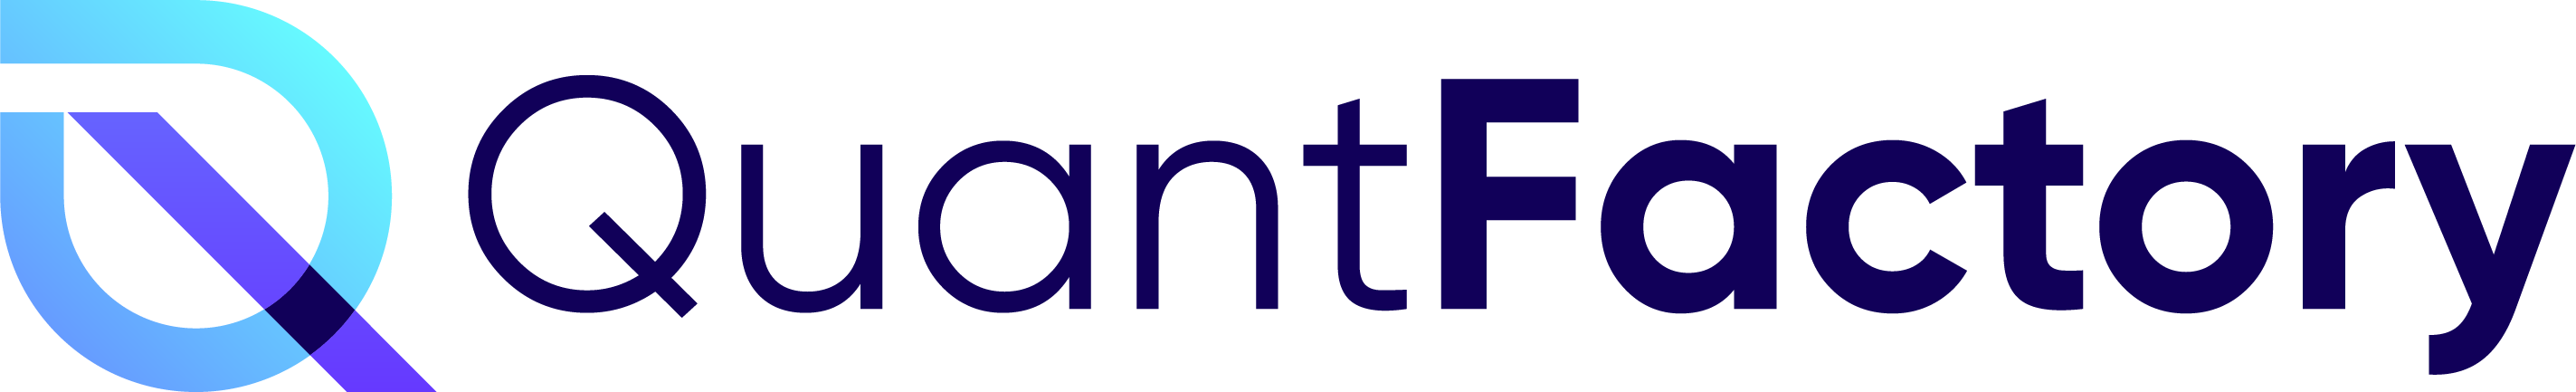

In [4]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')

stock_df = yf.download(tickers='NVDA', start='2012-01-01', end='2023-01-29')

nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

nvda_log

[*********************100%***********************]  1 of 1 completed


Date
2012-01-04 00:00:00-05:00    0.011331
2012-01-05 00:00:00-05:00    0.035286
2012-01-06 00:00:00-05:00   -0.011624
2012-01-09 00:00:00-05:00    0.000000
2012-01-10 00:00:00-05:00   -0.004135
                               ...   
2023-01-23 00:00:00-05:00    0.073159
2023-01-24 00:00:00-05:00    0.003744
2023-01-25 00:00:00-05:00    0.003006
2023-01-26 00:00:00-05:00    0.024487
2023-01-27 00:00:00-05:00    0.028035
Name: Adj Close, Length: 2785, dtype: float64

In [6]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    x.plot(ax=axes[0][0], title='Residuals')
    
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    axes[1][0].set_xlabel('Lag')
    
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    
    sns.despine()
    
    fig.tight_layout()
    
    fig.subplots_adjust(top=.9)
    
    return

# Visualizing Daily Volatility Correlogram

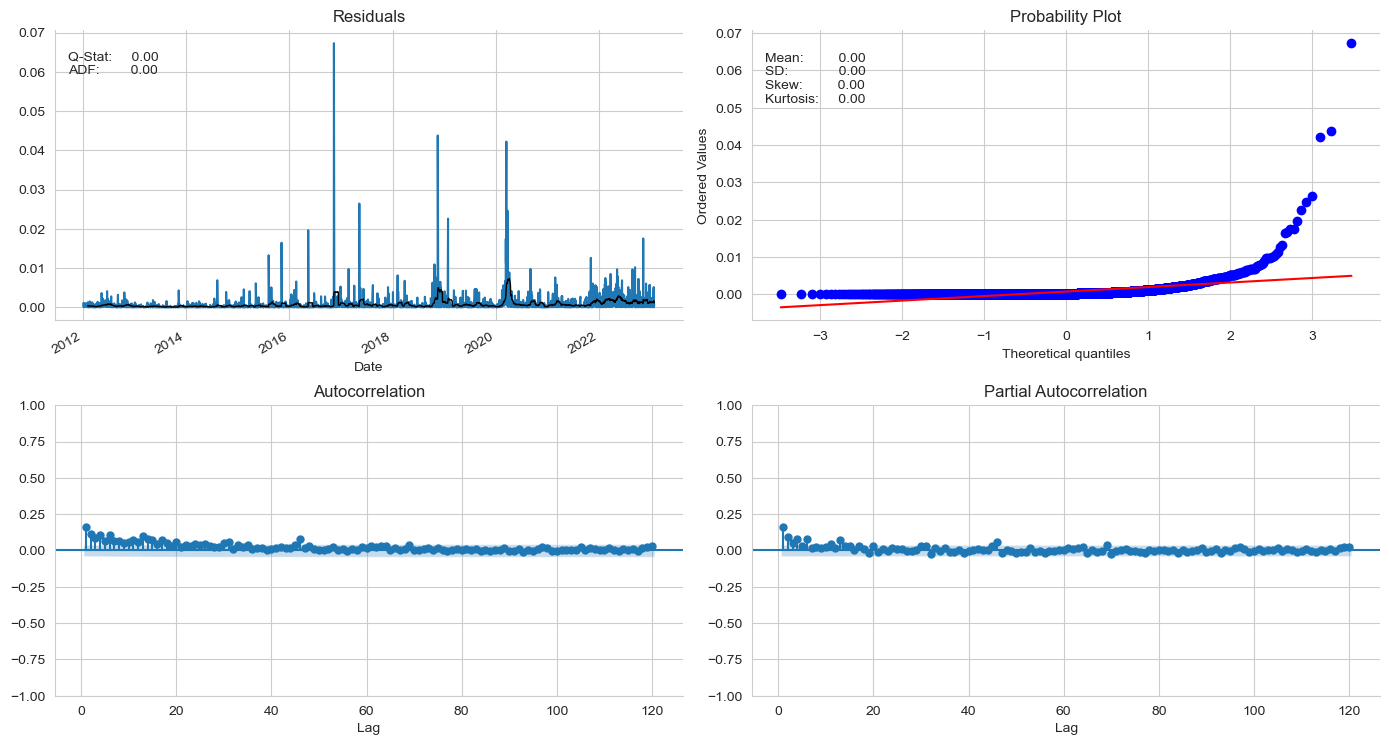

In [7]:
nvda_daily_vol = (nvda_log-nvda_log.mean())**2

plot_correlogram(x=nvda_daily_vol,
                 lags=120,
                 title=None)

In [8]:
from arch import arch_model

#number of year data * Working days of a year #############
trainsize = 10 * 252

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [11]:
results

{(1, 1): 0.0007352542004228019,
 (1, 2): 0.0007328865941093527,
 (1, 3): 0.0007314678419975526,
 (1, 4): 0.000731987284822439,
 (2, 1): 0.0007335124362916515,
 (2, 2): 0.00072927225311566,
 (2, 3): 0.0007300124914174297,
 (2, 4): 0.000727417154889861,
 (3, 1): 0.0007318157985204868,
 (3, 2): 0.0007274137309844022,
 (3, 3): 0.0007263666511610643,
 (3, 4): 0.0007262371938097103,
 (4, 1): 0.0007311852721680346,
 (4, 2): 0.0007255692468517975,
 (4, 3): 0.0007259606144712378,
 (4, 4): 0.0007329317525787559}

In [12]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(4, 2, 0)

In [9]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

 ######################### Confiqure the Model with above result  ##############################################

best_model = arch_model(y=data, p=4, q=2).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6938.09
Distribution:                  Normal   AIC:                          -13860.2
Method:            Maximum Likelihood   BIC:                          -13812.7
                                        No. Observations:                 2785
Date:                Tue, Jan 31 2023   Df Residuals:                     2784
Time:                        09:34:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5453e-03  3.577e-04      4.319  1.565e-05 [8.

In [13]:
data = nvda_log.to_frame('nvda_log_ret')

################ Here we take last 70 working days ###########################################

data['variance'] = data['nvda_log_ret'].rolling(70).var()

################ Here, Year have to change ###########################################

data = data['2020':]

def predict_volatility(x):  
    
    ######################### Confiqure the Model with above result  ##############################################
    
    best_model = arch_model(y=x, p=4, q=2).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

data['predictions'] = data['nvda_log_ret'].rolling(70).apply(lambda x: predict_volatility(x))

data = data.dropna()

data

2020-04-13 00:00:00-04:00
2020-04-14 00:00:00-04:00
2020-04-15 00:00:00-04:00
2020-04-16 00:00:00-04:00
2020-04-17 00:00:00-04:00
2020-04-20 00:00:00-04:00
2020-04-21 00:00:00-04:00
2020-04-22 00:00:00-04:00
2020-04-23 00:00:00-04:00
2020-04-24 00:00:00-04:00
2020-04-27 00:00:00-04:00
2020-04-28 00:00:00-04:00
2020-04-29 00:00:00-04:00
2020-04-30 00:00:00-04:00
2020-05-01 00:00:00-04:00
2020-05-04 00:00:00-04:00
2020-05-05 00:00:00-04:00
2020-05-06 00:00:00-04:00
2020-05-07 00:00:00-04:00
2020-05-08 00:00:00-04:00
2020-05-11 00:00:00-04:00
2020-05-12 00:00:00-04:00
2020-05-13 00:00:00-04:00
2020-05-14 00:00:00-04:00
2020-05-15 00:00:00-04:00
2020-05-18 00:00:00-04:00
2020-05-19 00:00:00-04:00
2020-05-20 00:00:00-04:00
2020-05-21 00:00:00-04:00
2020-05-22 00:00:00-04:00
2020-05-26 00:00:00-04:00
2020-05-27 00:00:00-04:00
2020-05-28 00:00:00-04:00
2020-05-29 00:00:00-04:00
2020-06-01 00:00:00-04:00
2020-06-02 00:00:00-04:00
2020-06-03 00:00:00-04:00
2020-06-04 00:00:00-04:00
2020-06-05 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-01 00:00:00-05:00
2021-03-02 00:00:00-05:00
2021-03-03 00:00:00-05:00
2021-03-04 00:00:00-05:00
2021-03-05 00:00:00-05:00
2021-03-08 00:00:00-05:00
2021-03-09 00:00:00-05:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-10 00:00:00-05:00
2021-03-11 00:00:00-05:00
2021-03-12 00:00:00-05:00


C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-15 00:00:00-04:00
2021-03-16 00:00:00-04:00
2021-03-17 00:00:00-04:00
2021-03-18 00:00:00-04:00
2021-03-19 00:00:00-04:00
2021-03-22 00:00:00-04:00
2021-03-23 00:00:00-04:00
2021-03-24 00:00:00-04:00
2021-03-25 00:00:00-04:00
2021-03-26 00:00:00-04:00
2021-03-29 00:00:00-04:00
2021-03-30 00:00:00-04:00
2021-03-31 00:00:00-04:00
2021-04-01 00:00:00-04:00
2021-04-05 00:00:00-04:00
2021-04-06 00:00:00-04:00
2021-04-07 00:00:00-04:00
2021-04-08 00:00:00-04:00
2021-04-09 00:00:00-04:00
2021-04-12 00:00:00-04:00
2021-04-13 00:00:00-04:00
2021-04-14 00:00:00-04:00
2021-04-15 00:00:00-04:00
2021-04-16 00:00:00-04:00
2021-04-19 00:00:00-04:00
2021-04-20 00:00:00-04:00
2021-04-21 00:00:00-04:00
2021-04-22 00:00:00-04:00
2021-04-23 00:00:00-04:00
2021-04-26 00:00:00-04:00
2021-04-27 00:00:00-04:00
2021-04-28 00:00:00-04:00
2021-04-29 00:00:00-04:00
2021-04-30 00:00:00-04:00
2021-05-03 00:00:00-04:00
2021-05-04 00:00:00-04:00
2021-05-05 00:00:00-04:00
2021-05-06 00:00:00-04:00
2021-05-07 0

C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Developer\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-12-10 00:00:00-05:00
2021-12-13 00:00:00-05:00
2021-12-14 00:00:00-05:00
2021-12-15 00:00:00-05:00
2021-12-16 00:00:00-05:00
2021-12-17 00:00:00-05:00
2021-12-20 00:00:00-05:00
2021-12-21 00:00:00-05:00
2021-12-22 00:00:00-05:00
2021-12-23 00:00:00-05:00
2021-12-27 00:00:00-05:00
2021-12-28 00:00:00-05:00
2021-12-29 00:00:00-05:00
2021-12-30 00:00:00-05:00
2021-12-31 00:00:00-05:00
2022-01-03 00:00:00-05:00
2022-01-04 00:00:00-05:00
2022-01-05 00:00:00-05:00
2022-01-06 00:00:00-05:00
2022-01-07 00:00:00-05:00
2022-01-10 00:00:00-05:00
2022-01-11 00:00:00-05:00
2022-01-12 00:00:00-05:00
2022-01-13 00:00:00-05:00
2022-01-14 00:00:00-05:00
2022-01-18 00:00:00-05:00
2022-01-19 00:00:00-05:00
2022-01-20 00:00:00-05:00
2022-01-21 00:00:00-05:00
2022-01-24 00:00:00-05:00
2022-01-25 00:00:00-05:00
2022-01-26 00:00:00-05:00
2022-01-27 00:00:00-05:00
2022-01-28 00:00:00-05:00
2022-01-31 00:00:00-05:00
2022-02-01 00:00:00-05:00
2022-02-02 00:00:00-05:00
2022-02-03 00:00:00-05:00
2022-02-04 0

,nvda_log_ret,variance,predictions
Date,,,
2020-04-13 00:00:00-04:00,0.025902,0.002955,0.001583
2020-04-14 00:00:00-04:00,0.050932,0.002985,0.001985
2020-04-15 00:00:00-04:00,-0.011013,0.002983,0.001230
2020-04-16 00:00:00-04:00,0.048173,0.003013,0.001357
2020-04-17 00:00:00-04:00,-0.008109,0.003013,0.001539
...,...,...,...
2023-01-23 00:00:00-05:00,0.073159,0.001440,0.001659
2023-01-24 00:00:00-05:00,0.003744,0.001437,0.001362
2023-01-25 00:00:00-05:00,0.003006,0.001422,0.001345


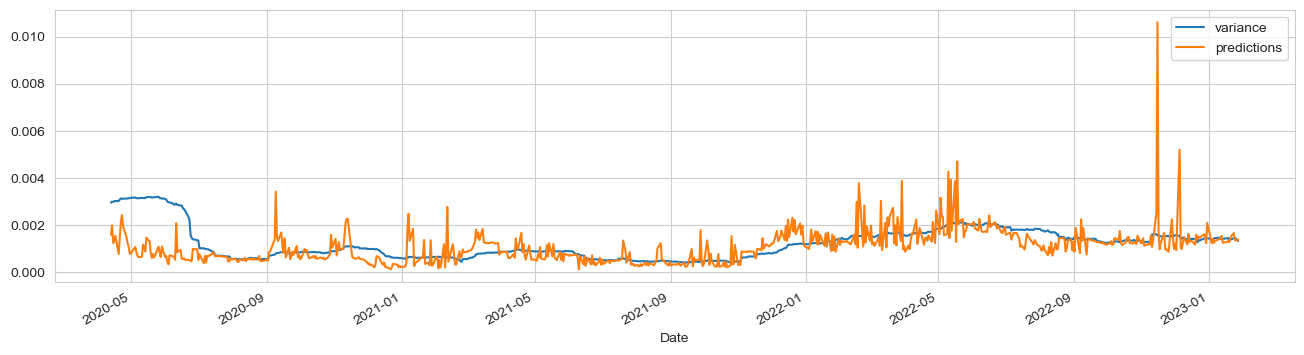

In [14]:
data[['variance', 'predictions']].plot(figsize=(16,4))

plt.show()

In [15]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['predictions'])

data

,nvda_log_ret,variance,predictions,fixed_predictions
Date,,,,
2020-04-13 00:00:00-04:00,0.025902,0.002955,0.001583,0.000792
2020-04-14 00:00:00-04:00,0.050932,0.002985,0.001985,0.001195
2020-04-15 00:00:00-04:00,-0.011013,0.002983,0.001230,0.001204
2020-04-16 00:00:00-04:00,0.048173,0.003013,0.001357,0.001236
2020-04-17 00:00:00-04:00,-0.008109,0.003013,0.001539,0.001291
...,...,...,...,...
2023-01-23 00:00:00-05:00,0.073159,0.001440,0.001659,0.001430
2023-01-24 00:00:00-05:00,0.003744,0.001437,0.001362,0.001424
2023-01-25 00:00:00-05:00,0.003006,0.001422,0.001345,0.001416


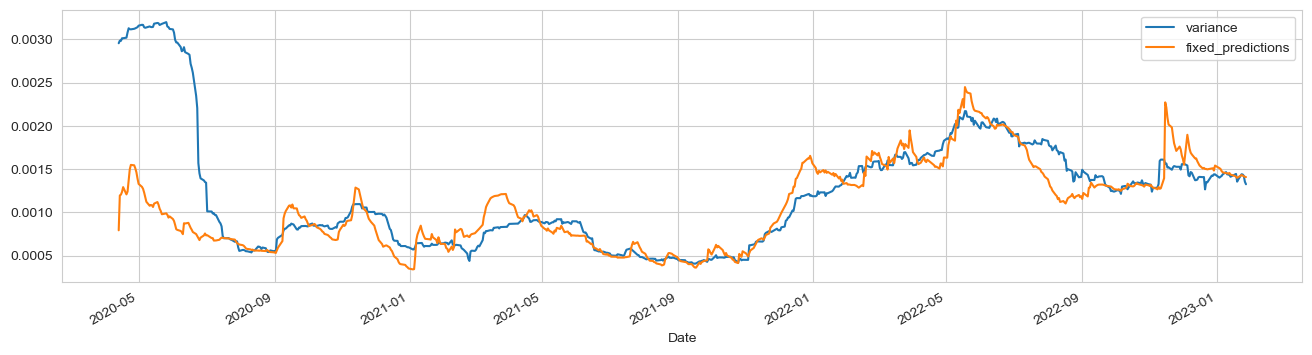

In [16]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))

plt.show()

In [1]:
np.exp(np.log1p(data['nvda_log_ret']).cumsum()).plot(figsize=(16,4))

plt.title('Cummulative Return')

plt.show()

NameError: name 'np' is not defined

In [28]:
print(f"Sharpe Ratio : {(data['nvda_log_ret'].mean()/data['nvda_log_ret'].std())*(252**.5)}")

Sharpe Ratio : 0.7783536524726559


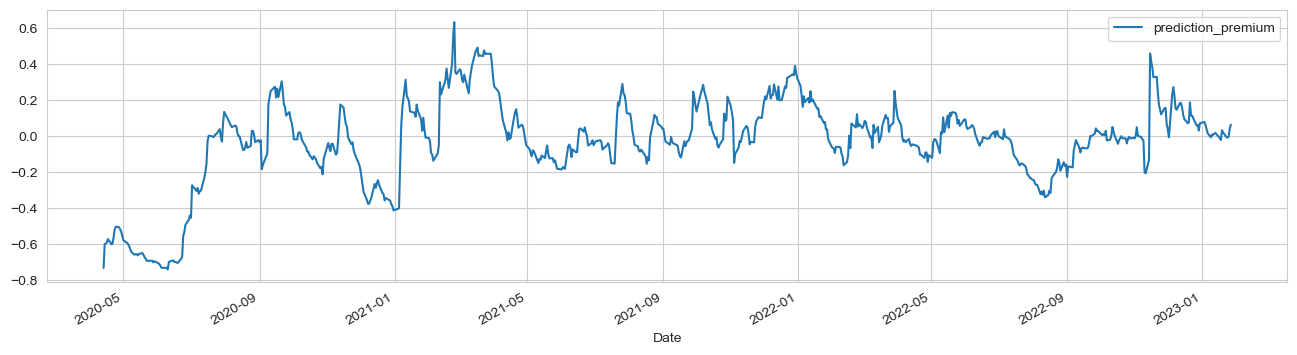

In [22]:
data['prediction_premium'] = (data['fixed_predictions']-data['variance'])/data['variance']

data[['prediction_premium']].plot(figsize=(16,4))

plt.show()

In [25]:
data['premium_diff'] = data['prediction_premium'].diff()

std = data['prediction_premium'].diff().std()

data['signal'] = data.apply(lambda x: 1 if (x['prediction_premium']<0)&(x['premium_diff']>std)
                            else (-1 if (x['prediction_premium']>0)&(x['premium_diff']<-std) else np.nan), axis=1)

data['signal'] = data['signal'].ffill(limit=5)

data['strategy_return'] = (data['nvda_log_ret']*data['signal'])

data

,nvda_log_ret,variance,predictions,fixed_predictions,prediction_premium,premium_diff,signal,strategy_return
Date,,,,,,,,
2020-04-13 00:00:00-04:00,0.025902,0.002955,0.001583,0.000792,-0.732140,NaN,NaN,NaN
2020-04-14 00:00:00-04:00,0.050932,0.002985,0.001985,0.001195,-0.599809,0.132331,1.0,0.050932
2020-04-15 00:00:00-04:00,-0.011013,0.002983,0.001230,0.001204,-0.596430,0.003379,1.0,-0.011013
2020-04-16 00:00:00-04:00,0.048173,0.003013,0.001357,0.001236,-0.589708,0.006721,1.0,0.048173
2020-04-17 00:00:00-04:00,-0.008109,0.003013,0.001539,0.001291,-0.571581,0.018127,1.0,-0.008109
...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-05:00,0.073159,0.001440,0.001659,0.001430,-0.006430,-0.026760,NaN,NaN
2023-01-24 00:00:00-05:00,0.003744,0.001437,0.001362,0.001424,-0.008898,-0.002468,NaN,NaN
2023-01-25 00:00:00-05:00,0.003006,0.001422,0.001345,0.001416,-0.003908,0.004991,NaN,NaN


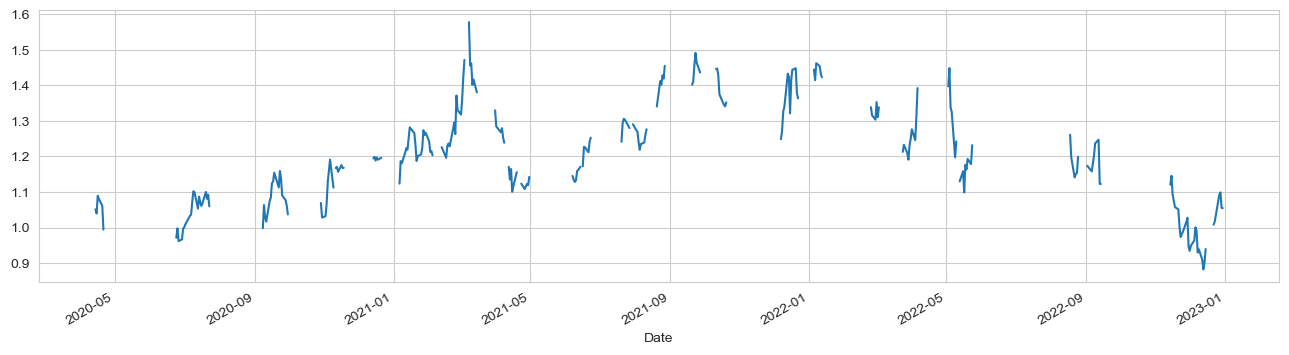

In [26]:
np.exp(np.log1p(data['strategy_return']).cumsum()).plot(figsize=(16,4))

plt.show()

In [29]:
print(f"Strategy Sharpe Ratio : {(data['strategy_return'].mean()/data['strategy_return'].std()) * (252**.5)}")

Strategy Sharpe Ratio : 0.36118163467665765
